In this Notebook we want to demonstrate what happens to the cumulative number of hospitalisations over a particular time period, when we alter one parameter ceteris paribus. We consider **four scenarios**:
1. Containment (patient zero is local in province g)
2. Protection (patient zero is someplace else in h != g)

In each of these cases, perform a parameter rescaling ...
1. Rescale mobility to and from g (from 1 to 0)
2. Rescale non-home-related social contact (from 1 to 0)

and leave all other parameters intact. This means we have to take the following steps in this particular order:
1. Load all packages. Show the corner plot of the latest calibration
2. Load initial values on January 1st 2020. Let's look at Brussels, and have patient zero in Brussels or in Luxembourg.
2. Load all model data. In particular ...
    - Loop over values for `p`
    - Loop over values for alpha that rescale `Nc_all` = `Nc_home` + `alpha` * (`Nc_schools` + ...)
    - Mobility is average mobility pre-pandemic
    - No vaccinations, no VOCs, no seasonality, ...
    - Either (this is a question) have the best-fit parameter values, or sample from the dict. In the latter case, we need to perform at least 10 and preferably 100 simulations per parameter value.
4. Load the model *without* time-dependent parameter functions
5. Execute the model over *one wave* and look at the cumulative number of hospitalisations at e.g. May 1st
6. Add this number to an array and at the end of the loop, plot the p/alpha array against the cumulative number of hospitalisations

Remaining questions:
1. Should we take one particular set of parameter values, or should we sample from the parameter dict? Choosing the latter would mean that we need many more draws for the relation to converge neatly - but it would look nicer. Choosing the former would mean that the parameters don't really fit together. The cornerplot can be created in `notebooks/calibration/MR-postprocessing-calibration.ipynb`
2. How do we make people act that are forced to stay at home?
    - Either force subjects that stay at home to actually behave according to stay-at-home contact
    - Either have all social contact identical everywhere (standard `Nc_all`)

# Load Python packages

In [25]:
# Load packages
# Established packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.models.utils import initial_state
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_VOC_function
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'prov'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 # Load initial values and key model parameters

In [149]:
# FIRST CHOICE: initial outbreak in Brussels (21000) or in luxembourg (80000)
init_NIS = 80000

initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial=agg)

VOCs = ['WT', 'abc', 'delta']
VOC_logistic_growth_parameters, VOC_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(initN, params['h'], VOCs=VOCs)
params.update(VOC_params)

# Define the matrix of exposed subjects that will be identified with compartment E
age = -1 # hard-coded as following the demographic distribution
init_number = 100
initE = initial_state(dist=init_NIS, agg=agg, age=age, number=init_number, age_stratification_size=10)

# Add the susceptible and exposed population to the initial_states dict
initial_states = {'S': initN.values-initE, 'E': initE}

# Overwrite Nc_work: people behave the same regardless of where they go
params['Nc_work'] = Nc_dict['total']

# Drop all parameters that are not part of this simple model
params.pop('amplitude')
params.pop('eff_schools')
params.pop('eff_home')
params.pop('default_mobility')
params.pop('eff_work')
params.pop('l1')
params.pop('peak_shift')
params.pop('l2')
params.pop('eff_rest')
params.pop('mentality')
params.pop('e_s')
params.pop('onset_days')
params.pop('d_vacc')
params.pop('e_h')
params.pop('stop_idx')
params.pop('N_vacc')
params.pop('vacc_order')
params.pop('delay_immunity')
params.pop('f_immune_escape')
params.pop('e_i')
params.pop('initN')
params.pop('refusal')
params.pop('daily_doses')
params.pop('doses')

# Add parameters that are part of the model but are not changed (default values)
params['seasonality']=1
params['E_hosp'] = np.ones([11,10])
params['E_susc'] = np.ones([11,10])
params['E_inf'] = np.ones([11,10])

# Load model parameter values

In [150]:
# Add clearly distinct infectivity parameters for demonstration
beta_R = 0.0253
beta_U = 0.0249
beta_M = 0.0314
params.update({'beta_R' : beta_R,
               'beta_U' : beta_U,
               'beta_M' : beta_M})

# Add default prepandemic mobility matrix
mobility_update_function = make_mobility_update_function(mobility.get_proximus_mobility_data('prov'))
P_matrix = np.zeros([11, 11])
start_date = pd.Timestamp(2020, 1, 1)
duration=21
for d in range(duration):
    date = start_date + pd.Timedelta(days=d)
    P_matrix += mobility_update_function(date)
P_matrix /= duration
params.update({'place' : P_matrix})

# Loop over `p` values and initialise

Text(0.5, 0.98, 'Effect of manipulating mobility to/from Brussels')

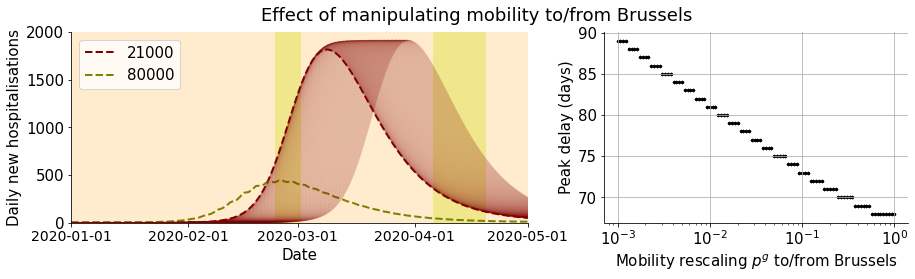

In [152]:
from matplotlib import gridspec as gs
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ticklabelsize = 12
ax0.set_xlim(start_date, end_date)
ax0.set_ylim(0, 2000)
# ax.set_yticks([0, 0.005, 0.01])

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax0, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)


# original simulation
params['p'] = np.ones(11)
model = models.COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial=agg)

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-01')
warmup = 0

out = model.sim(end_date, start_date=start_date, warmup=warmup)

out['H_in'].sel(place=21000).sum(dim='Nc').plot(ax=ax0, color='maroon', label='21000', linewidth=2, linestyle='--')
out['H_in'].sel(place=80000).sum(dim='Nc').plot(ax=ax0, color='olive', label='80000', linewidth=2, linestyle='--')

# Brussels is index 3; Luxembourg is index 9
pg_index = 3
pg_values = np.logspace(0, -3, 100) # np.linspace(0.99, 0, 100)
# initialise argmax array
argmax_array = []
for pg_value in pg_values:

    p = params['p']
    p[pg_index] = pg_value
    params['p'] = p

    # Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
    model = models.COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial=agg)
    
    # run model
    out = model.sim(end_date, start_date=start_date, warmup=warmup)

    # Overplot with alpha
    out['H_in'].sel(place=21000).sum(dim='Nc').plot(ax=ax0, color='maroon', linewidth=1, alpha=0.2)
    # out['H_in'].sel(place=80000).sum(dim='Nc').plot(ax=ax0, color='olive', linewidth=1, alpha=0.2)
    
    argmax = float(out['H_in'].sel(place=21000).sum(dim='Nc').argmax().values)
    argmax_array.append(argmax)

    ax0.set_title(None)
    ax0.grid(False)
    ticklabelsize = 14
    ax0.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    ax0.set_xlabel(None)
    ax0.set_ylabel('Daily hospitalisations')
    
ax1.scatter(np.array(pg_values), np.array(argmax_array), s=3, color='k', marker='x')
ax1.set_xscale('log')
ax1.set_xlabel('Mobility rescaling $p^g$ to/from Brussels')
ax1.set_ylabel('Peak delay (days)')

# plt.tight_layout()

# ax0.set_title(None)
ax0.grid(False)
ticklabelsize = 14
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 2, 1).date(), pd.Timestamp(2020, 3, 1).date(), \
               pd.Timestamp(2020, 4, 1).date(), pd.Timestamp(2020, 5, 1).date()]
ax0.legend(loc=2)
ax0.set_xlabel('Date')
ax0.set_ylabel('Daily new hospitalisations')
ax0.set_xticks(ticks=xticks)
ax0.set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')

fig.suptitle("Effect of manipulating mobility to/from Brussels")

In [147]:
pd.Timestamp(2020, 1, 1)

2020

In [ ]:
pd.Timestamp(2020, 1, 1).date

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(13,6))

infected(out.sel(place=44000), ax=ax1)
ax1.grid(False)
ax1.set_xlabel(None)
ax1.set_title("1 exposed 40-somethings dropped in Brussels. Evolution in Ghent.", fontsize=14)
ax1.get_legend().remove()

# infected(out.sel(place=21000), ax=ax2)
infected(out.sum(dim='place'), ax=ax2)
ax2.grid(False)
ax2.set_xlabel(None)
ax2.set_title("Evolution in Belgium.", fontsize=14)
ax2.get_legend().remove()

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
# plt.savefig("test", dpi=400, bb_boxes='tight')